# Random forest

    Este modelo es un bagging con muchos árboles de decisión de muy poca profundidad (max_depth = 1, 2)
---
    [ES] Código de Alfredo Cuesta Infante para 'Reconocimiento de Patrones'
       @ Master Universitario en Visión Artificial, 2023, URJC (España)
    [EN] Code by Alfredo Cuesta-Infante for 'Pattern Recognition'
       @ Master of Computer Vision, 2023, URJC (Spain)

    alfredo.cuesta@urjc.es

## Imports & carga de datos

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.manifold import LocallyLinearEmbedding, Isomap, TSNE
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron
from sklearn.svm import LinearSVC, NuSVC, LinearSVR, NuSVR, SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, accuracy_score
import matplotlib.pyplot as plt

#########################################################################

pathStr = "../datasets/0vs1/"
[file_X, file_Y] = [pathStr+'setX_0vs1.csv', pathStr+'setY_0vs1.csv']
X_init = pd.read_csv(file_X, sep=';', header=None, dtype=int)
Y_init = pd.read_csv(file_Y, sep=';', header=None, dtype=int)

X_train_init, X_test_init, Y_train_init, Y_test_init = train_test_split(X_init, Y_init, test_size=0.33, random_state=1234)

## Pipeline de transformación de datos

### Clases para empaquetar transformadores de datos

In [2]:
class Pixels_to_Unit(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X/255.0


class ExtractFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, theta=0.1):
        self.theta = theta

    def fit(self, X, y=None):
        return self # return fun_feat_extract(X, theta = self.theta)

    def transform(self, X):
        
        def fun_feat_extract(data, theta=0.1):
            # data: dataframe
            # theta: parameter of the feature extraction
            #
            features = np.zeros([data.shape[0], 8]) #<- allocate memory with zeros
            data = data.values.reshape([data.shape[0],28,28]) 
            #-> axis 0: id of instance, axis 1: width(cols) , axis 2: height(rows)
            for k in range(data.shape[0]):
                #..current image 
                x = data[k,:,:]
                #--width feature
                sum_cols = x.sum(axis=0) #<- axis0 of x, not of data!!
                indc = np.argwhere(sum_cols > theta * sum_cols.max())
                col_3maxs = np.argsort(sum_cols)[-3:] 
                features[k,0] = indc[-1] - indc[0]
                features[k,1:4] = col_3maxs
                #--width feature
                sum_rows = x.sum(axis=1) #<- axis1 of x, not of data!!
                indr = np.argwhere(sum_rows > theta * sum_rows.max())
                features[k,4] = indr[-1] - indr[0]
                row_3maxs = np.argsort(sum_rows)[-3:] 
                features[k,5:8] = row_3maxs
            col_names = ['width','W_max1','W_max2','W_max3','height','H_max1','H_max2','H_max3']
            return pd.DataFrame(features,columns = col_names)  
    
        return fun_feat_extract(X, theta = self.theta)   
#---------------------------------------------------------------------------------------

class FeatureAreaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self # return get_feat_area(X)

    def transform(self, X):
        
        def get_feat_area(features):
            values = features['width'] * features['height']
            return pd.DataFrame({'area':values})
        
        return get_feat_area(X)
    
#---------------------------------------------------------------------------------------

class FeatureWoverHTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self # return get_feat_WoverH(X)

    def transform(self, X):

        def get_feat_WoverH(features):
            values = features['width'] / features['height']
            values = values.round(decimals=2)
            return pd.DataFrame({'WoverH':values})  

        return get_feat_WoverH(X) 

### Pipeline de transformación

In [3]:
preprocess = []    #--------------

scaler1 = Pixels_to_Unit()
preprocess.append(('scaler1', scaler1))

theta = 0.05 #<-it ranges in [0,.5]
extractor = ExtractFeaturesTransformer(theta=theta)
preprocess.append( ('extractor', extractor) )
pipe1 = Pipeline(preprocess)

more_features = [] #--------------

poly_degree = 2
polyfeat = PolynomialFeatures(poly_degree).set_output(transform="pandas")
more_features.append( ('addPolyFeat', polyfeat) )
              
more_features.append( ('addArea', FeatureAreaTransformer()) )

more_features.append( ('addWoverH', FeatureWoverHTransformer()) )

pipe2 = FeatureUnion(more_features)

LLEprocess = []  #--------------

n_components = 8
n_neighbors = 50
random_state = 1234
max_iter = 200
LLEprocess.append((
    'lle',
     LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components,
                            max_iter=max_iter, random_state=random_state).set_output(transform='pandas') )
)

scaler2 = MinMaxScaler().set_output(transform='pandas')
LLEprocess.append( ('scaler2', scaler2) )

pipe3 = Pipeline(LLEprocess)

pipe_Data = Pipeline([('pipe1',pipe1),('pipe2',pipe2),('pipe3',pipe3)])

### Aprendizaje de la transformación

In [4]:
pipe_Data.fit(X_train_init)
X_train_d = pipe_Data.transform(X_train_init)

C:\Users\alfredo.cuesta\AppData\Local\Temp\ipykernel_7492\3160502829.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features[k,0] = indc[-1] - indc[0]
C:\Users\alfredo.cuesta\AppData\Local\Temp\ipykernel_7492\3160502829.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features[k,4] = indr[-1] - indr[0]
C:\Users\alfredo.cuesta\AppData\Local\Temp\ipykernel_7492\3160502829.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features[k,0] = indc[-1] - indc[0

## Pipeline del modelo

In [5]:
n_estimators = 100
max_leaf_nodes = 16
max_depth = 1

RF_clf = RandomForestClassifier(n_estimators=n_estimators,
                                max_depth=max_depth)
                                #max_leaf_nodes=max_leaf_nodes)

pipe_Clf = Pipeline([('RF_clf', RF_clf)])

In [6]:
pipe_Clf

Pipeline(steps=[('RF_clf', RandomForestClassifier(max_depth=1))])

In [7]:
pipe_Clf.fit(X_train_d, Y_train_init)
y_hat= pipe_Clf.predict(X_train_d)
print('Confusion matrix:\n',pd.DataFrame(confusion_matrix(Y_train_init, y_hat)))
accuracy = accuracy_score(Y_train_init, y_hat)

C:\Users\alfredo.cuesta\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Confusion matrix:
      0    1
0  259   40
1    8  363


## Visualización

feature 0 -> imporance = 0.15
feature 1 -> imporance = 0.26
feature 2 -> imporance = 0.18
feature 3 -> imporance = 0.02
feature 4 -> imporance = 0.17
feature 5 -> imporance = 0.04
feature 6 -> imporance = 0.18
feature 7 -> imporance = 0.00


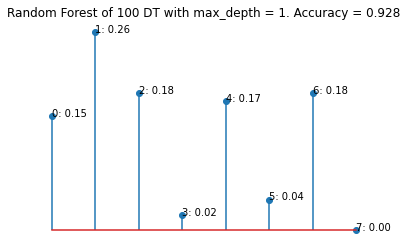

In [8]:
plt.rcParams['figure.figsize'] = [6,6]

for i in range(n_components):
    score = pipe_Clf[0].feature_importances_[i]
    strResult = "feature %d -> imporance = %2.2f" %(i,score)
    print(strResult)
    
plt.stem(pipe_Clf[0].feature_importances_)

for i in range(n_components):
    strImportance = "%d: %2.2f" %(i,pipe_Clf[0].feature_importances_[i])
    plt.text(i+0.4, RF_clf.feature_importances_[i], strImportance, horizontalalignment='center')

plt.axis('off')
plt.xlabel('Feature')
plt.ylabel('Importance')
strTitle = 'Random Forest of %d DT with max_depth = %d. Accuracy = %1.3f' %(n_estimators, max_depth, accuracy)
#strTitle = 'Random Forest of %d DT with max_leaf_nodes = %d. Accuracy = %1.3f' %(n_estimators, max_leaf_nodes, accuracy)
plt.title(strTitle)
plt.show()